In [1]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import pandas as pd
import yfinance as yf
from stockstats import StockDataFrame
import yfinance as yf

# plot
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
sns.set(font="IPAexGothic", rc={'figure.figsize':(11,8)}) 
pd.options.display.float_format = '{:6.2f}'.format

/usr/local/lib/python3.9/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
# Valid start and end: YYYY-MM-DD
# Valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
# Valid intervals: [1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]
response = yf.download(
        tickers = "SOXL",
        period = "1y",
        interval = "1d",
        group_by = 'ticker',
)

[*********************100%***********************]  1 of 1 completed


In [3]:
yfdata = response.copy().dropna()
# yfdata = yfdata["1950-01":"202１-12"] # 直近の暴落を除いて検証する
yfdata

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-05-14,30.49,32.68,29.58,31.93,31.92,21881300
2021-05-17,30.98,31.10,29.43,31.10,31.09,19224800
2021-05-18,31.71,32.08,30.22,30.29,30.28,15262600
2021-05-19,28.46,32.17,28.22,32.05,32.04,29208700
2021-05-20,32.75,34.98,32.67,34.64,34.63,28593200
...,...,...,...,...,...,...
2022-05-09,21.82,22.60,19.32,19.72,19.72,72482100
2022-05-10,21.45,22.15,19.72,21.09,21.09,72934500
2022-05-11,20.53,22.00,18.97,19.15,19.15,76546000


In [4]:
def convert_df_to_stock_df(df: pd.DataFrame) -> StockDataFrame:
    sdf = df.copy()
    sdf.rename(columns={
        'Open': 'open',
        'High': 'high',
        'Low': 'low',
        'Close': 'close',
        'Adj Close': 'amount',
        'Volume': 'volume',
    }, inplace=True)
    sdf.index.names = ['date']
    return StockDataFrame(sdf)

def SMA(arr: pd.DataFrame, n: int) -> pd.Series:
    samsdf = convert_df_to_stock_df(arr)
    sma = samsdf[sdf_SMA_key(n)]
    return sma

def sdf_SMA_key(n: int) -> str:
    return 'close_'+str(n)+'_sma'

/usr/local/lib/python3.9/site-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 2211 configurations.
  output = _optimize_grid()


Start                     2021-05-14 00:00:00
End                       2022-05-13 00:00:00
Duration                    364 days 00:00:00
Exposure Time [%]                       22.53
Equity Final [$]                     13733.10
Equity Peak [$]                      16451.10
Return [%]                              37.33
Buy & Hold Return [%]                  -29.56
Return (Ann.) [%]                       37.16
Volatility (Ann.) [%]                   62.72
Sharpe Ratio                             0.59
Sortino Ratio                            1.34
Calmar Ratio                             1.86
Max. Drawdown [%]                      -20.02
Avg. Drawdown [%]                      -10.07
Max. Drawdown Duration      137 days 00:00:00
Avg. Drawdown Duration       32 days 00:00:00
# Trades                                    1
Win Rate [%]                           100.00
Best Trade [%]                          37.44
Worst Trade [%]                         37.44
Avg. Trade [%]                    

<Figure size 792x576 with 0 Axes>

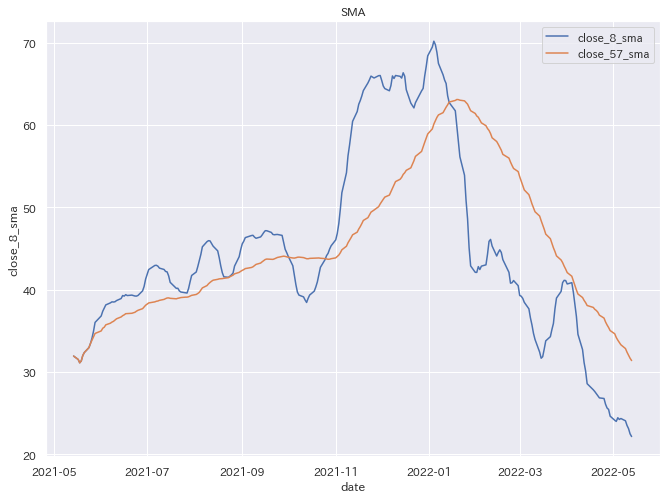

<Figure size 792x576 with 0 Axes>

In [5]:
class SmaCross(Strategy):
    n1 = 10
    n2 = 20

    def init(self):
        self.sma1 = self.I(SMA, self.data.df, self.n1)
        self.sma2 = self.I(SMA, self.data.df, self.n2)

    def next(self):
        if crossover(self.sma1, self.sma2):
            self.buy()
        elif crossover(self.sma2, self.sma1):
            self.position.close()
            
bt = Backtest(yfdata,
              SmaCross,
              cash=10000, commission=.002,
              exclusive_orders=True)

# 出力
# output = bt.run()
# print(output)
# bt.plot()

#最適化
optimize=bt.optimize(
    n1=range(3, 70, 1),
    n2=range(4, 70, 1),
    method='grid', # unuse model-based optimization
    constraint=lambda p: p.n1 < p.n2,
    maximize='Equity Final [$]'
)
bt.plot()
print(optimize)
print(optimize._strategy)

# print sma
sma1 = optimize._strategy.n1
sma2 = optimize._strategy.n2
key1 = sdf_SMA_key(sma1)
key2 = sdf_SMA_key(sma2)

plot_df = pd.DataFrame(SMA(yfdata, sma1)).join(SMA(yfdata, sma2))
sns.lineplot(data = plot_df, x='date', y=key1).set_title('SMA')
sns.lineplot(data = plot_df, x='date', y=key2)
plt.legend(labels=[key1,key2])
plt.figure()